In [3]:
import os
import numpy as np
import torch
import json

import cv2 as cv

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import random

In [132]:
def padCrop(img, targetSize):
    h, w, c = 0, 0, 1
        
    try:
        h, w, c = img.shape
    except:
        h, w = img.shape

    mH, mW, mC = 0, 0, 1
    try:
        mH, mW, mC = targetSize
    except:
        mH, mW = targetSize

    pz = np.zeros(targetSize, dtype=np.uint8)

    bH, bW, bC = mH, mW, mC

    if(bH > h):
        bH = h

    if(bW > w):
        bW = w

    if(bC == 1 and c == 3):
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        c = 1
    elif(bC == 3 and c == 1):
        img = np.stack([img, img, img], axis=-1)
        c = 3

    pz[0:bH, 0:bW, :] = img[0:bH, 0:bW, :]
    
    return pz

In [142]:
#dirs is list of list [[imgDir, maskDir], ...] or [dir1, dir2, dir3] if both mask and img are in same dir
#file name of img and mask must be in format <prefix>_<count>_Mask.<ext>

class ImgDatasetMultiClass(object):
    def __init__(self, transform, colorFormat, dirs, targetSize):
        
        self.imgs = []
        self.masks = []
        self.colorFormat = colorFormat
        self.targetSize = targetSize
        
        for d in dirs:
            if(type(d) is list):
                iDir = d[0]
                mDir = d[1]
                
                mFiles = [f for f in os.listdir(mDir) if ((".PNG" in f) or (".png" in f) or (".JPG" in f) or (".jpg" in f))]
    
                for m in mFiles:
                    self.masks.append(os.path.join(mDir, m))
                    self.imgs.append(os.path.join(iDir, m.replace("_Mask", "")))
                
            else:
                fDir = d
                mFiles = [f for f in os.listdir(fDir) if "_Mask" in f and ((".PNG" in f) or (".png" in f) or (".JPG" in f) or (".jpg" in f))]
                for m in mFiles:
                    self.masks.append(os.path.join(fDir, m))
                    self.imgs.append(os.path.join(fDir, m.replace("_Mask", "")))
        
        self.transforms = transform
        
    def __getitem__(self, ind):
        
        img = cv.imread(self.imgs[ind])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        mask = cv.imread(self.masks[ind])
        mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
        
        if(self.targetSize is not None):
            img = padCrop(img, self.targetSize)
            mask = padCrop(mask, self.targetSize)
        
        colors = set(tuple(v) for m in mask for v in m)
        
        boxes = []
        labels = []
        masks = []
        imageId = []
        
        rgbMax = np.array([256,256,256], dtype=np.uint8)
        hsvMax = np.array([180,256,256], dtype=np.uint8)
        
        for c in colors:
            if(c == (0,0,0)):
                continue
        
            bMask = np.logical_and(np.logical_and(mask[:,:,0] == c[0], mask[:,:,1] == c[1]), mask[:,:,2] == c[2])
        
            pos = np.where(bMask)
            xMin = np.min(pos[1])
            xMax = np.max(pos[1])
            yMin = np.min(pos[0])
            yMax = np.max(pos[0])
            
            boxes.append([xMin, yMin, xMax, yMax])
            masks.append(bMask)
            
            for k,v in self.colorFormat.items():                
                print(k,v, c)
                cL = np.array(v[1])
                cH = np.array(v[2])
                co = c
                
                if(np.any(cL > cH)):
                    
                    if(self.colorFormat[k][0] == "H"):
                        cnH = cL + np.multiply(hsvMax, cL>cH)
                        co = cv.cvtColor(c, cv.COLOR_RGB2HSV)
                    elif(self.colorFormat[k] == "R"):
                        cnH = cL + np.multiply(rgbMax, cL>cH)
                        
                    s = np.stack([cH, cnH], axis=-1)
                    cL = np.min(s, axis=-1)
                    cH = np.max(s, axis=-1)
                
                
                if(np.all(cL <= co) and np.all(co <= cH)):
                    print("Append", k)
                    labels.append(int(k))
                    break
            else:
                labels.append(0)                
        
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        print(labels)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        
        imageId = torch.tensor([ind])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        isCrowd = torch.zeros((len(colors),), dtype=torch.int64)
        
        target = dict()
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = imageId
        target["area"] = area
        target["iscrowd"] = isCrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [130]:
i1[0].shape

(1236, 1626, 3)

In [131]:
plt.imshow(padCrop(i1[0], [1600,1600,3]))

In [86]:
import json

In [88]:
with open("file1.txt", 'r') as f:
    cF = json.load(f)

In [89]:
cF

{'1': ['R', [250, 0, 0], [255, 0, 0]], '2': ['R', [0, 0, 250], [0, 0, 255]]}

In [104]:
dirs= [["Bad", "BadMask"],["Good", "GoodMask"]]

In [143]:
ds1 = ImgDatasetMultiClass(None,cF,dirs, (1300,1600,3))

In [144]:
ds1.imgs

['Bad/Bad - 019.png',
 'Bad/Bad - 079.png',
 'Bad/Bad - 107.png',
 'Bad/Bad - 004.png',
 'Bad/Bad - 003.png',
 'Bad/Bad - 117.png',
 'Bad/Bad - 039.png',
 'Bad/Bad - 105.png',
 'Bad/Bad - 083.png',
 'Bad/Bad - 059.png',
 'Bad/Bad - 024.png',
 'Bad/Bad - 028.png',
 'Bad/Bad - 017.png',
 'Bad/Bad - 023.png',
 'Bad/Bad - 115.png',
 'Bad/Bad - 048.png',
 'Good/Good - 003.png',
 'Good/Good - 002.png',
 'Good/Good - 009.png',
 'Good/Good - 008.png',
 'Good/Good - 014.png',
 'Good/Good - 015.png',
 'Good/Good - 000_T.png',
 'Good/Good - 013.png',
 'Good/Good - 012.png',
 'Good/Good - 004.png',
 'Good/Good - 005.png',
 'Good/Good - 000.png',
 'Good/Good - 001.png',
 'Good/Good - 007.png',
 'Good/Good - 006.png',
 'Good/Good - 010.png',
 'Good/Good - 011.png']

In [145]:
i1 = ds1[-6]

1 ['R', [250, 0, 0], [255, 0, 0]] (250, 0, 0)
Append 1
1 ['R', [250, 0, 0], [255, 0, 0]] (0, 0, 255)
2 ['R', [0, 0, 250], [0, 0, 255]] (0, 0, 255)
Append 2
1 ['R', [250, 0, 0], [255, 0, 0]] (0, 0, 254)
2 ['R', [0, 0, 250], [0, 0, 255]] (0, 0, 254)
Append 2
[1, 2, 2]


In [146]:
i1

(array([[[41, 41, 41],
         [45, 45, 45],
         [47, 47, 47],
         ...,
         [64, 64, 64],
         [66, 66, 66],
         [67, 67, 67]],
 
        [[43, 43, 43],
         [45, 45, 45],
         [45, 45, 45],
         ...,
         [69, 69, 69],
         [69, 69, 69],
         [69, 69, 69]],
 
        [[45, 45, 45],
         [44, 44, 44],
         [44, 44, 44],
         ...,
         [70, 70, 70],
         [64, 64, 64],
         [70, 70, 70]],
 
        ...,
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]], dtype=uint8),
 {'boxes': tensor([[ 510.,  123., 1538.,  

<IPython.core.display.Javascript object>


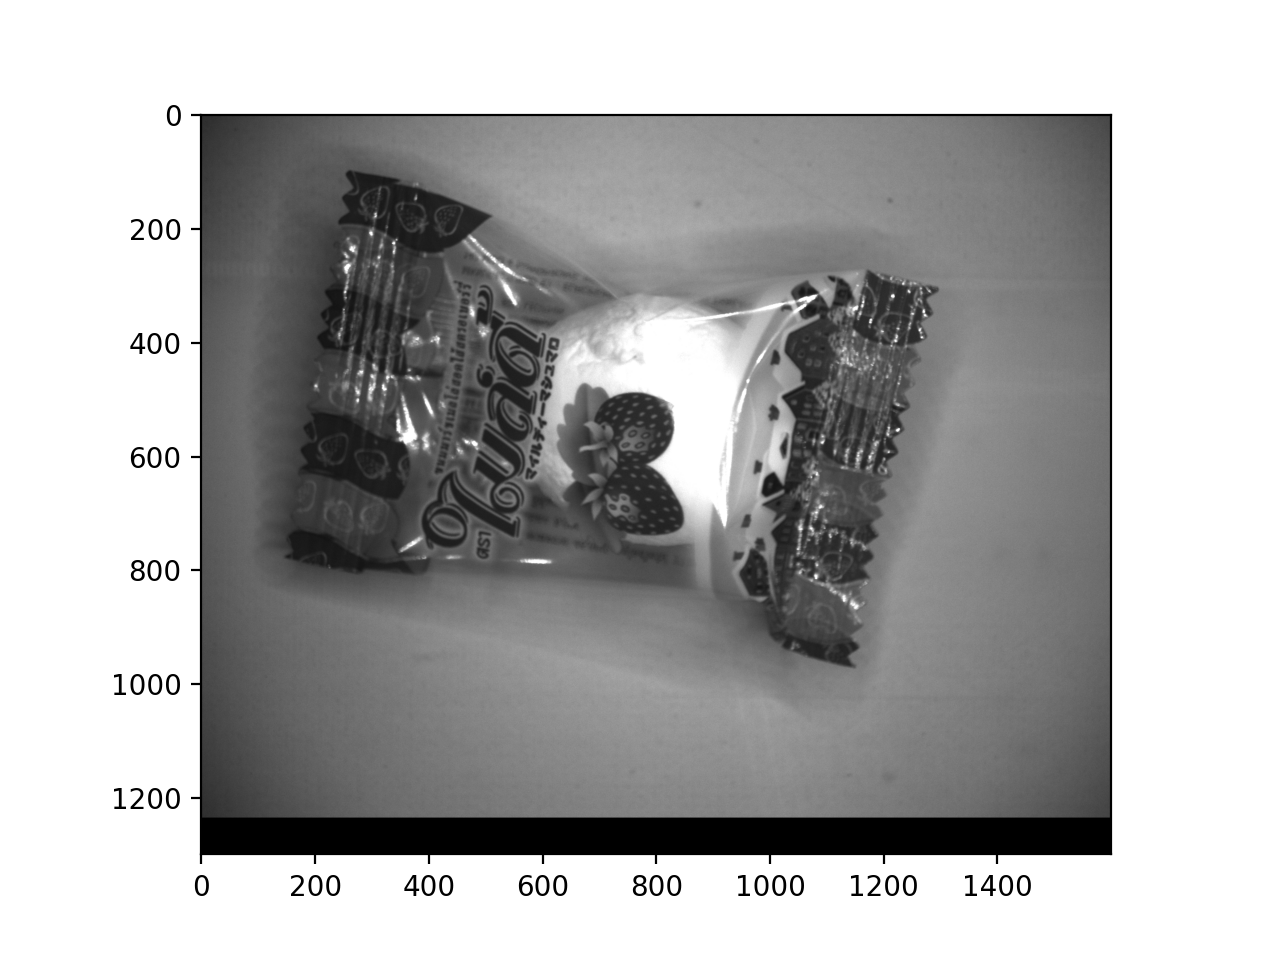

In [147]:
fig1 = plt.figure()
plt.imshow(i1[0])

<IPython.core.display.Javascript object>


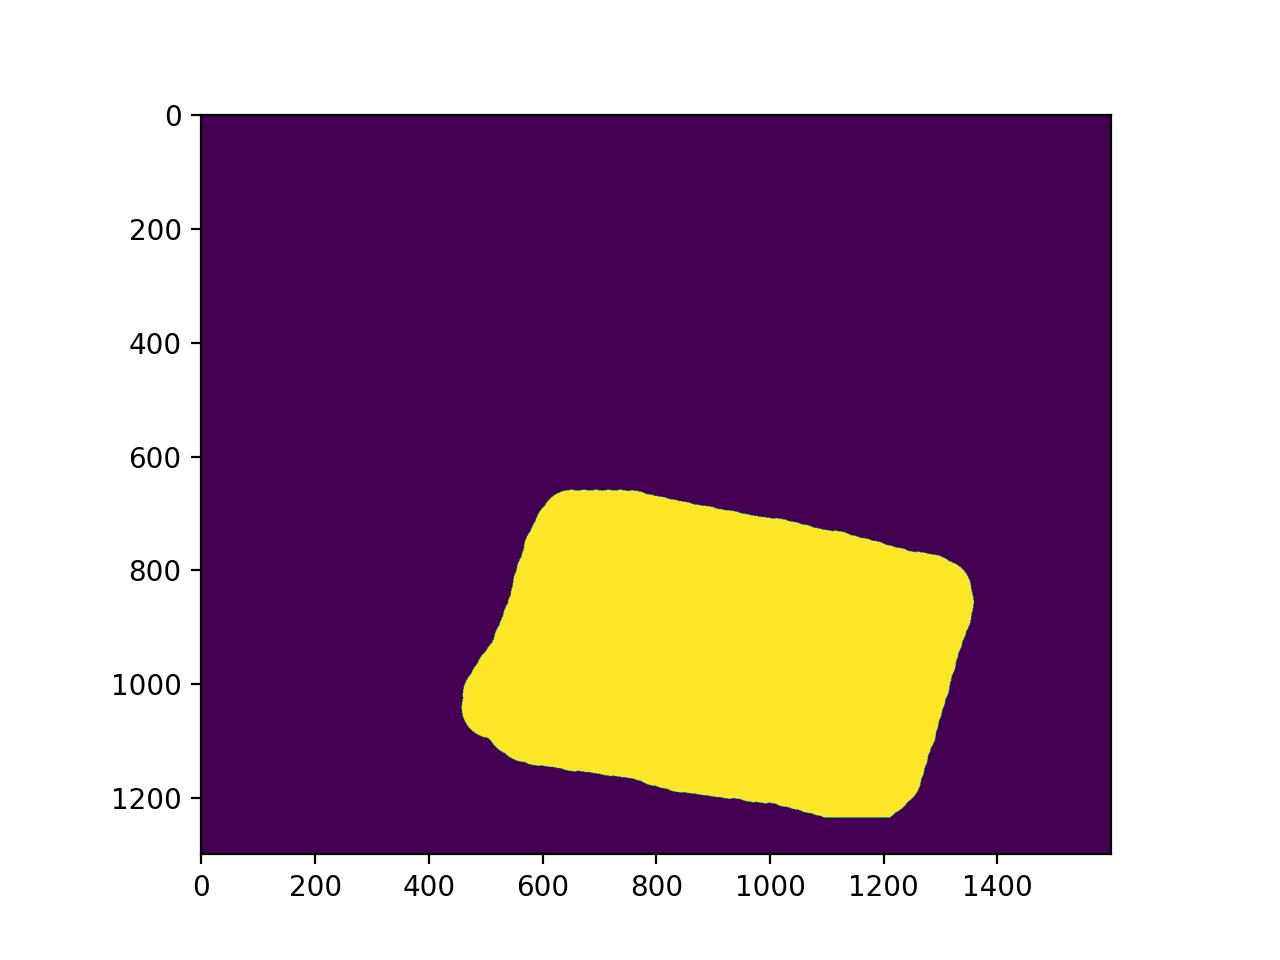

In [148]:
fig2 = plt.figure()
plt.imshow(i1[1]["masks"][2])

In [8]:
#dirs is list of list [[imgDir, maskDir, class], ...] or [[dir1, class1], [dir2, class2], [dir3, class3], ...] if both mask and img are in same dir
#file name of img and mask must be in format <prefix>_<count>_Mask.<ext>
class ImgDatasetBinayMask(object):
    def __init__(self, transform, colorFormat, dirs):
        
        self.imgs = []
        self.masks = []
        self.labs = []
        
        for d in dirs:
            if(len(d) == 3):
                iDir = d[0]
                mDir = d[1]
                lab = d[2]
                
                mFiles = os.listdir(mDir)
                
                for m in mFiles:
                    self.masks.append(os.path.join(mDir, m))
                    self.imgs.append(os.path.join(iDir, m.replace("_Mask", "")))
                self.labs.extend([lab] * len(mFiles))
                
            else:
                fDir = d[0]
                lab = d[1]
                
                mFiles = [f for f in os.listdir(fDir) if "_Mask" in f]
                for m in mFiles:
                    self.masks.append(os.path.join(fDir, m))
                    self.imgs.append(os.path.join(fDir, m.replace("_Mask", "")))
                self.labs.extend([lab] * len(mFiles))
        
        self.transforms = transform
        
    def __getitem__(self, ind):
        
        img = cv.imread(self.imgs[ind])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        mask = cv.imread(self.masks[ind])
        mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
        
        boxes = []
        pos = np.where(mask)
        xMin = np.min(pos[1])
        xMax = np.max(pos[1])
        yMin = np.min(pos[0])
        yMax = np.max(pos[0])
        boxes.append([xMin, yMin, xMax, yMax])
        
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        
        labels = [self.labs[ind]]
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array([mask]), dtype=torch.uint8)
        
        imageId = torch.tensor([ind])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        isCrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = dict()
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = imageId
        target["area"] = area
        target["iscrowd"] = isCrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

        
    def __len__(self):
        return len(self.imgs)

In [9]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
from engine import train_one_epoch, evaluate
import utils

def train(datasetType, colorFormat, trainDir, testDir, modelI=None, modelO="model.pt", num_epochs=10, print_freq=10):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


    num_classes = len(imageFormat)-1

    dataset = datasetType(get_transform(train=True), colorFormat, trainDir)
    dataset_test = datasetTyoe(get_transform(train=False), colorFormat, testDir)

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=0,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=utils.collate_fn)

    model = None
    
    if(modelI is not None):    
        model = torch.load(modelI)
    else:
        model = get_model_instance_segmentation(num_classes)

    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=print_freq)
        lr_scheduler.step()
        evaluate(model, data_loader_test, device=device)
        
    torch.save(model, modelO)